In [ ]:
!pip install chicken-dinner

     |████████████████████████████████| 32.1 MB 77.9 MB/s 
Mounted at /content/drive


telemetry 정보가 있는 csv 파일 오픈

In [ ]:
from chicken_dinner.pubgapi import PUBG
import pandas as pd

api_key =
pubg = PUBG(api_key=api_key, shard="steam")

match_info = pd.read_csv('/content/pcs3kr_telemetry.csv')
match_info = match_info.drop(columns='Unnamed: 0')
match_info.shape # 40, 6

(40, 6)

In [ ]:
import pandas as pd
import json
from pandas import json_normalize

l = []

for x in range(len(match_info)):
    match = match_info.matchId[x]
    tel = pubg.telemetry(match_info.telemetry_path[x])

    damage = tel.filter_by('log_player_take_damage')
    attack = tel.filter_by('log_player_attack')
    kill = tel.filter_by('log_player_kill')

    for i in range(len(damage)):
      l.append(json.loads(damage[i].dumps()))
    for i in range(len(attack)):
      l.append(json.loads(attack[i].dumps()))
    for i in range(len(kill)):
      l.append(json.loads(kill[i].dumps()))

df = pd.DataFrame(l)

In [ ]:
# 코드 재사용
import pandas as pd
import json
from pandas import json_normalize

ㅣ= []

for x in range(len(match_info)):
  tel = pubg.telemetry(match_info.telemetry_path[x])

In [ ]:
# 시간별 정렬 후 인덱스 초기화 / NaN을 None으로 전환
df.sort_values(by=['_D'], axis=0).reset_index(inplace=True)
df = df.where(pd.notnull(df), None)
df.shape # 342154, 24

(342154, 23)

In [ ]:
# NonSpecific 제거 / shot damage만 남기기위해
idx = df[ df.damage_reason == 'NonSpecific' ].index
df.drop(idx, inplace=True)
df.reset_index(inplace=True)
df.shape # 275663, 25

(275663, 24)

In [ ]:
# 교전 분리하기
battle = {}
df_battle = df.copy()
df_battle['battle_type'] = 'NotBattle'
df_battle['attacker_name'] = None
df_battle['victim_name'] = None
df_battle['killer_name'] = None

for i in range(len(df_battle)):
  if i % 10000 == 0:
    print(i)

  if df_battle.loc[i]._T == 'LogPlayerAttack':
    attacker = df_battle.loc[i].attacker['name']
    df_battle.loc[i, 'attacker_name'] = attacker
    
    if attacker in battle.keys(): # 교전중인 Attacker
      df_battle.loc[i, 'battle_type'] = 'Attacker'
    elif attacker in battle.values(): # 교전중인 Defender
      df_battle.loc[i, 'battle_type'] = 'Defender'

  elif df_battle.loc[i]._T == 'LogPlayerTakeDamage':
    attacker = df_battle.loc[i].attacker['name']
    victim = df_battle.loc[i].victim['name']
    battle_reverse = dict((y, x) for (x, y) in battle.items())

    df_battle.loc[i, 'attacker_name'] = attacker
    df_battle.loc[i, 'victim_name'] = victim

    # 교전중인 Attacker
    if attacker in battle.keys():
      df_battle.loc[i, 'battle_type'] = 'Attacker'

      if victim != battle[attacker]: # 교전중인 Attacker가 다른 대상을 공격시 
        battle[attacker] = victim # 교전대상 초기화
    
    # 교전중인 Defender
    elif attacker in battle.values():
      if victim == battle_reverse[attacker]: # 교전중인 Defender가 교전 상대를 공격시
        df_battle.loc[i, 'battle_type'] = 'Defender'
      
      else: # 교전중인 Defender가 다른 대상을 공격시
        battle[attacker] = victim # Defender의 교전 삭제후 Attacker로써의 교전시작
        df_battle.loc[i, 'battle_type'] = 'Attacker'
        del battle[battle_reverse[attacker]]
   
    else: # 교전시작!!!
      df_battle.loc[i, 'battle_type'] = 'Attacker'
      battle[attacker] = victim

  else: # LogPlayerKill
    killer = df_battle.loc[i].killer['name']
    victim = df_battle.loc[i].victim['name']
    battle_reverse = dict((y, x) for (x, y) in battle.items())

    df_battle.loc[i, 'killer_name'] = killer
    df_battle.loc[i, 'victim_name'] = victim

    # Attacker인 Killer
    if killer in battle.keys():
      df_battle.loc[i, 'battle_type'] = 'Attacker'
      del battle[killer] # 교전 초기화

    # Defender인 Killer
    elif killer in battle.values():

      if victim == battle_reverse[killer]: # 교전중인 Defender가 Attacker를 죽일시
        df_battle.loc[i, 'battle_type'] = 'Defender'
        del battle[victim]

      else: # 교전중인 Defender가 교전중이지 않은 대상을 죽일시에도 Defender로써의 교전은 초기화된다.
        df_battle.loc[i, 'battle_type'] = 'Attacker'
        del battle[battle_reverse[killer]] # 원래 교전대상인 Attacker이름을 찾아 교전 초기화

df_battle.drop(['is_through_penetrable_wall', 'common', 'attack_id', 'index', 'vehicle', 'dbno_id', 'attacker', 'victim', 'killer'], axis=1, inplace=True)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


In [ ]:
df_battle

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,None,None,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Defender,None,None,None
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,None,None,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,None,None,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275658,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,[Item_Attach_Weapon_Magazine_ExtendedQuickDraw...,NotBattle,None,None,None
275659,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle,None,None,None
275660,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle,None,None,None
275661,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",Attacker,None,None,None


In [ ]:
df_for_merge = df[['_D', '_T', 'attacker', 'victim', 'killer']]
df_for_merge

,_D,_T,attacker,victim,killer
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.958ca9d8dce148608b30e9...,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,{'account_id': 'account.958ca9d8dce148608b30e9...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None
...,...,...,...,...,...
275658,2020-10-10T12:32:47.911Z,LogPlayerKill,None,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,{'account_id': 'account.9e92c9973af24793b897dc...
275659,2020-10-10T12:32:47.923Z,LogPlayerKill,None,{'account_id': 'account.ad848f65767c4223a3d88f...,{'account_id': 'account.60ea8a6fdf204764b561a3...
275660,2020-10-10T12:32:47.932Z,LogPlayerKill,None,{'account_id': 'account.21ed0327799c4d19a97a33...,{'account_id': 'account.60ea8a6fdf204764b561a3...
275661,2020-10-10T12:33:12.147Z,LogPlayerKill,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,{'account_id': 'account.322cc67a3d924049a24129...


In [ ]:
df_for_merge['attacker_name'] = None
df_for_merge['victim_name'] = None
df_for_merge['killer_name'] = None

for i in range(len(df_for_merge)):
  if i % 10000 == 0:
    print(i)

  if df_for_merge.loc[i]._T == 'LogPlayerAttack':
    df_for_merge.loc[i, 'attacker_name'] = df_for_merge.loc[i].attacker['name']

  elif df_battle.loc[i]._T == 'LogPlayerTakeDamage':  
    df_for_merge.loc[i, 'attacker_name'] = df_for_merge.loc[i].attacker['name']
    df_for_merge.loc[i, 'victim_name'] = df_for_merge.loc[i].victim['name']
  
  else:
    df_for_merge.loc[i, 'killer_name'] = df_for_merge.loc[i].killer['name']
    df_for_merge.loc[i, 'victim_name'] = df_for_merge.loc[i].victim['name']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


In [ ]:
df_for_merge

,_D,_T,attacker,victim,killer,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.958ca9d8dce148608b30e9...,None,AZG_Untop,PG_LexGod,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,{'account_id': 'account.958ca9d8dce148608b30e9...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None,PG_LexGod,AZG_Untop,None
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None,AZG_Untop,AZG_Untop,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None,AZG_Untop,AZG_Untop,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,{'account_id': 'account.a7612ad6e7a34f2780095c...,{'account_id': 'account.a7612ad6e7a34f2780095c...,None,AZG_Untop,AZG_Untop,None
...,...,...,...,...,...,...,...,...
275658,2020-10-10T12:32:47.911Z,LogPlayerKill,None,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,{'account_id': 'account.9e92c9973af24793b897dc...,None,DNW_seoul,AF_daengchae
275659,2020-10-10T12:32:47.923Z,LogPlayerKill,None,{'account_id': 'account.ad848f65767c4223a3d88f...,{'account_id': 'account.60ea8a6fdf204764b561a3...,None,DNW_LeClo,AF_Hansia
275660,2020-10-10T12:32:47.932Z,LogPlayerKill,None,{'account_id': 'account.21ed0327799c4d19a97a33...,{'account_id': 'account.60ea8a6fdf204764b561a3...,None,DNW_Draft,AF_Hansia
275661,2020-10-10T12:33:12.147Z,LogPlayerKill,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,{'account_id': 'account.322cc67a3d924049a24129...,None,AF_Hansia,ENT_Seongjang


In [ ]:
df_for_merge.columns

Index(['_D', '_T', 'attacker', 'victim', 'killer', 'attacker_name',
       'victim_name', 'killer_name'],
      dtype='object')

In [ ]:
df_for_merge.drop(['_T','attacker', 'victim', 'killer'],axis=1, inplace = True)
df_for_merge

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,_D,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,AZG_Untop,PG_LexGod,None
1,2020-09-10T09:00:48.145Z,PG_LexGod,AZG_Untop,None
2,2020-09-10T09:00:58.252Z,AZG_Untop,AZG_Untop,None
3,2020-09-10T09:00:59.247Z,AZG_Untop,AZG_Untop,None
4,2020-09-10T09:01:00.251Z,AZG_Untop,AZG_Untop,None
...,...,...,...,...
275658,2020-10-10T12:32:47.911Z,None,DNW_seoul,AF_daengchae
275659,2020-10-10T12:32:47.923Z,None,DNW_LeClo,AF_Hansia
275660,2020-10-10T12:32:47.932Z,None,DNW_Draft,AF_Hansia
275661,2020-10-10T12:33:12.147Z,None,AF_Hansia,ENT_Seongjang


In [ ]:
df_battle.drop(['attacker_name', 'victim_name', 'killer_name'],axis=1, inplace = True)
df_battle

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Defender
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275658,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,[Item_Attach_Weapon_Magazine_ExtendedQuickDraw...,NotBattle
275659,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle
275660,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle
275661,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",Attacker


In [ ]:
merge_data = pd.merge(df_battle,df_for_merge, how='left', on='_D')
merge_data

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,PG_LexGod,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Defender,PG_LexGod,AZG_Untop,None
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284188,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,[Item_Attach_Weapon_Magazine_ExtendedQuickDraw...,NotBattle,None,DNW_seoul,AF_daengchae
284189,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle,None,DNW_LeClo,AF_Hansia
284190,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle,None,DNW_Draft,AF_Hansia
284191,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",Attacker,None,AF_Hansia,ENT_Seongjang


In [ ]:
merge_data.drop_duplicates(['_D', '_T', 'damage_causer_name'],inplace = True)
merge_data

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,PG_LexGod,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Defender,PG_LexGod,AZG_Untop,None
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,0.000000,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284188,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,[Item_Attach_Weapon_Magazine_ExtendedQuickDraw...,NotBattle,None,DNW_seoul,AF_daengchae
284189,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle,None,DNW_LeClo,AF_Hansia
284190,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle,None,DNW_Draft,AF_Hansia
284191,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",Attacker,None,AF_Hansia,ENT_Seongjang


In [ ]:
merge_data.to_csv('merge_data.csv')

In [ ]:
merge_data.damage_causer_name.value_counts() # groggy상태에서 무기=> PlayerFemale_A_C, damage => 0

PlayerFemale_A_C     22308
WeapBerylM762_C       7996
WeapFNFal_C           6449
PlayerMale_A_C        3688
WeapMini14_C          2963
WeapHK416_C           2112
WeapSKS_C             1386
WeapAK47_C            1019
WeapSCAR-L_C           531
WeapGroza_C             66
WeapMk14_C              53
WeapKar98k_C            53
WeapM16A4_C             27
WeapThompson_C          17
WeapM24_C               16
WeapMk47Mutant_C        15
WeapBizonPP19_C         11
WeapM249_C              10
WeapDP28_C              10
WeapAUG_C                9
WeapUMP_C                9
WeapUZI_C                7
WeapBerreta686_C         6
WeapSaiga12_C            4
WeapAWM_C                3
WeapMosinNagant_C        2
Name: damage_causer_name, dtype: int64

In [ ]:
# 자기장 데이터(LogplayerTakeDamage 본인-본인), 이상치(LogPlayerAttack  누가누구를 맞춘 정보)
merge_data[ (merge_data['_T'] == 'LogPlayerTakeDamage') & (merge_data['victim_name'] == merge_data['attacker_name']) ] #25323
merge_data[ (merge_data['_T'] == 'LogPlayerAttack') & merge_data['victim_name'] ] #2278

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
2,2020-09-10T09:00:58.252Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
3,2020-09-10T09:00:59.247Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
4,2020-09-10T09:01:00.251Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
5,2020-09-10T09:01:01.250Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
6,2020-09-10T09:01:02.239Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,AZG_Untop,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279002,2020-10-10T12:33:09.914Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,ENT_Seongjang,ENT_Seongjang,None
279003,2020-10-10T12:33:10.649Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AF_Hansia,AF_Hansia,None
279004,2020-10-10T12:33:10.909Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,ENT_Seongjang,ENT_Seongjang,None
279005,2020-10-10T12:33:11.654Z,LogPlayerTakeDamage,0.0,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,None,None,NaN,None,None,None,Attacker,AF_Hansia,AF_Hansia,None


In [ ]:
idx2 = merge_data[(merge_data._T == 'LogPlayerTakeDamage')  & (merge_data['victim_name'] == merge_data['attacker_name'])].index
merge_data.drop(idx2, inplace=True)

idx3 = merge_data[(merge_data['_T'] == 'LogPlayerAttack') & merge_data['victim_name']].index
merge_data.drop(idx3, inplace=True)

merge_data.reset_index(inplace=True)

In [ ]:
merge_data.drop(columns=['index'],axis=1, inplace=True)
merge_data

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,AZG_Untop,PG_LexGod,None
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Defender,PG_LexGod,AZG_Untop,None
2,2020-09-10T09:01:02.461Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,LegShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,PG_LexGod,AZG_Untop,None
3,2020-09-10T09:01:02.647Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,TorsoShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,PG_LexGod,AZG_Untop,None
4,2020-09-10T09:01:04.297Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,TorsoShot,Damage_Gun,None,NaN,None,None,None,NaN,None,None,None,Attacker,PG_LexGod,AZG_Untop,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246567,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,[Item_Attach_Weapon_Magazine_ExtendedQuickDraw...,NotBattle,None,DNW_seoul,AF_daengchae
246568,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle,None,DNW_LeClo,AF_Hansia
246569,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,None,NaN,None,{'account_id': 'account.60ea8a6fdf204764b561a3...,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle,None,DNW_Draft,AF_Hansia
246570,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,None,NaN,None,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"[Item_Attach_Weapon_Upper_DotSight_01_C, Item_...",Attacker,None,AF_Hansia,ENT_Seongjang


In [ ]:
merge_data.to_csv('merge_data_final.csv')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
merge_data = pd.read_csv('/content/merge_data_final.csv')

In [ ]:
#전체참여 선수
l = []

for x in range(len(match_info)):
    print(x)
    match = match_info.matchId[x]
    for i in pubg.telemetry(match_info.telemetry_path[x]).player_names():
      l.append(i)

l

In [ ]:
my_set = set(l) #집합set으로 변환
all_players = list(my_set) #list로 변환
len(all_players) #134명

133

In [ ]:
# 선수별 사격 정확도

df_list = []

for player_name in all_players:
    player_acc = []

     # 선수별 Log counting
    player_log = merge_data[ (merge_data['attacker_name'] == player_name) | (merge_data['killer_name'] == player_name)]._T.value_counts()
    
    player_acc.append(player_name)
    player_acc.append(player_log['LogPlayerAttack'])
    player_acc.append(player_log['LogPlayerTakeDamage'])
    player_acc.append(player_log['LogPlayerKill'])
    player_acc.append((sum(player_log)))
    player_acc.append((player_log['LogPlayerTakeDamage'] + player_log['LogPlayerKill']) / sum(player_log))

    df_list.append(player_acc)

shotacc_df= pd.DataFrame(df_list, columns = ['name', 'count_attack', 'count_take_damage', 'count_kill', 'count_sum', 'accuracy'])

In [ ]:
shotacc_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy
0,STA_Jungsae,884,91,11,986,0.103448
1,VSG_WICK2D,622,84,7,713,0.127630
2,LW_SSAK,800,59,4,863,0.073001
3,GZ_DParis,778,74,5,857,0.092182
4,GEN_Aqua5,2889,219,23,3131,0.077292
...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593
129,ENT_indigo,3416,341,43,3800,0.101053
130,GXG_Chaebin,672,119,10,801,0.161049
131,KP_Joy,2846,344,29,3219,0.115874


In [ ]:
shotacc_df.sort_values(by='accuracy', ascending=False)

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy
103,GG_Becky,516,97,13,626,0.175719
48,GXG_Vir,511,96,12,619,0.174475
130,GXG_Chaebin,672,119,10,801,0.161049
107,BJ_Joy,1238,190,19,1447,0.144437
32,AFK_Arden,670,102,10,782,0.143223
...,...,...,...,...,...,...
28,NCT_karlie,1134,54,4,1192,0.048658
91,STA_Tae9,610,27,3,640,0.046875
39,GRF_Feint,268,11,2,281,0.046263
6,AFK_Caley,463,19,3,485,0.045361


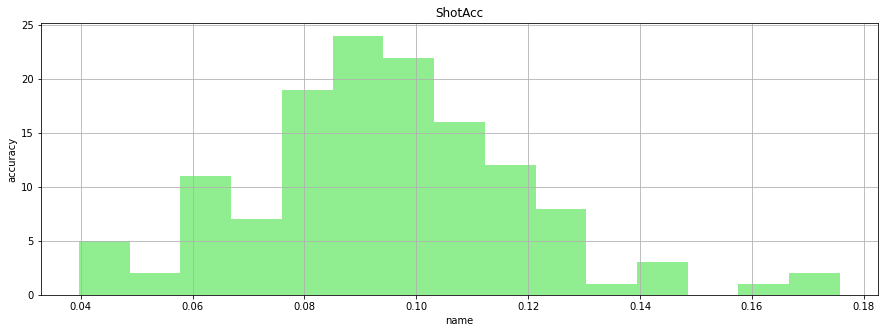

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(shotacc_df['accuracy'],bins=15,color='lightgreen')
plt.xlabel('name')
plt.ylabel('accuracy')
plt.title('ShotAcc')
plt.grid(True)

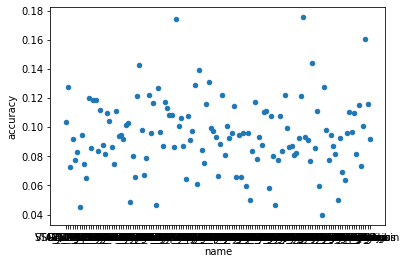

In [ ]:
shotacc_df.plot(x='name',y='accuracy', kind = 'scatter') #천차만별

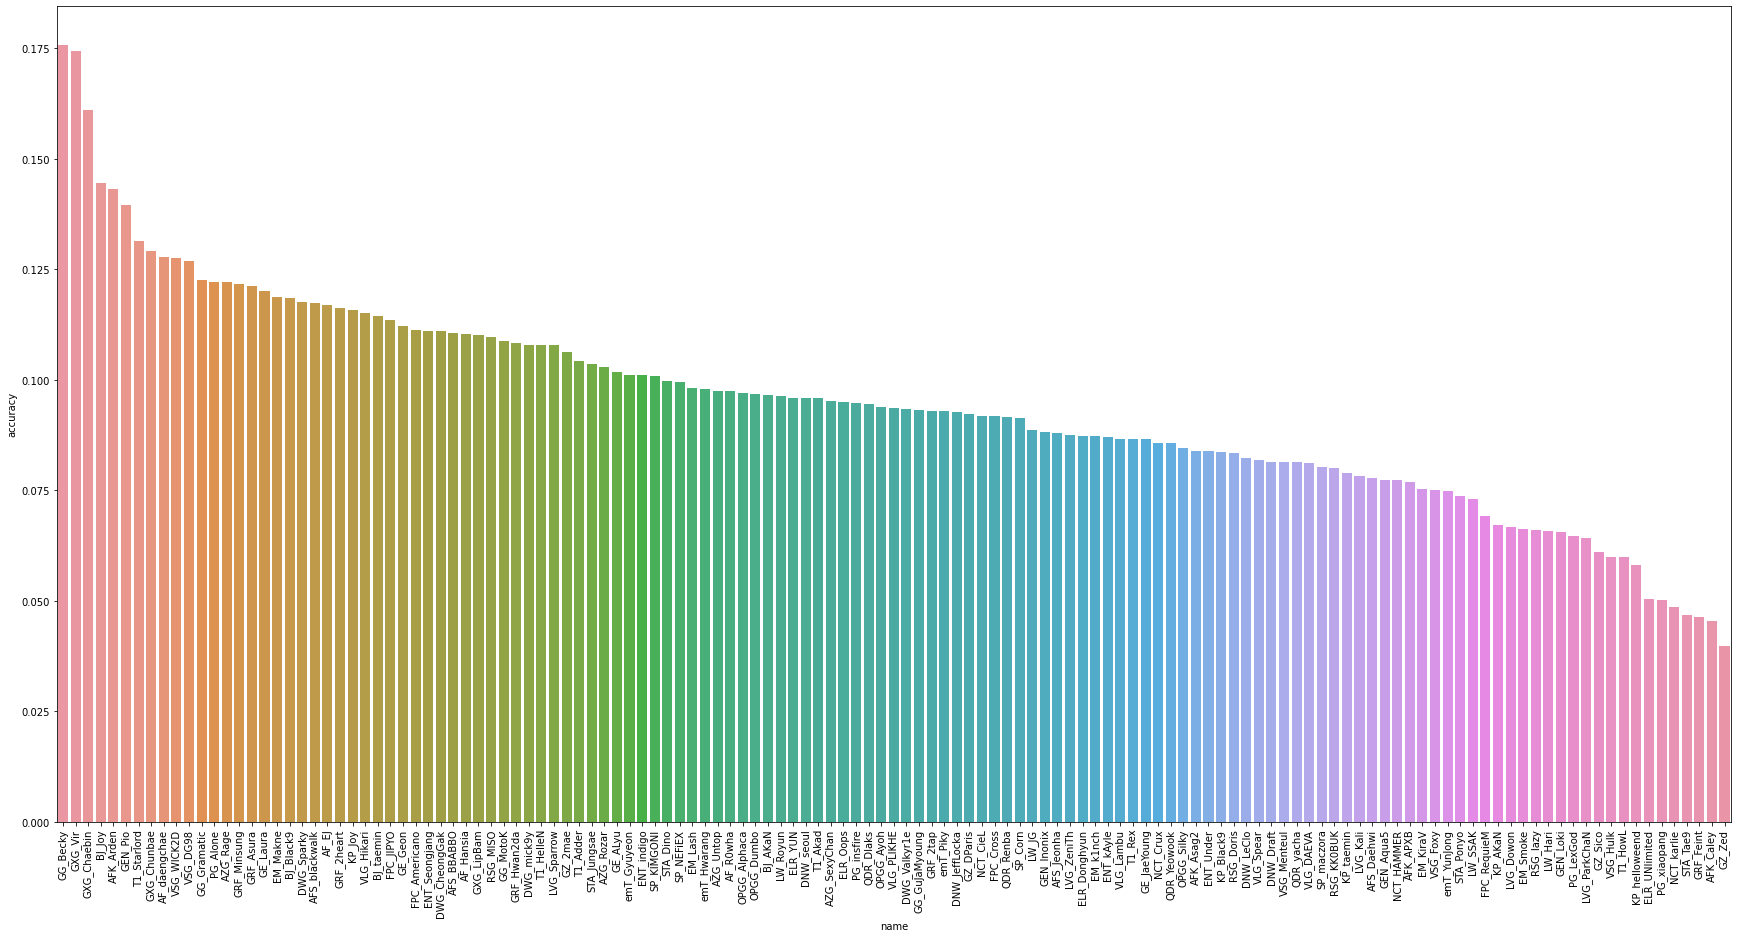

In [ ]:
plt.figure(figsize=(30,15))
bar_plot = sns.barplot(x = 'name', y = 'accuracy', data = shotacc_df.sort_values(by=['accuracy'], ascending=False))
plt.xticks(rotation=90)
plt.show()

In [ ]:
merge_data.columns

Index(['Unnamed: 0', '_D', '_T', 'damage', 'damage_causer_name',
       'damage_reason', 'damage_type_category', 'attack_type',
       'fire_weapon_stack_count', 'weapon', 'assistant',
       'damage_causer_additional_info', 'distance', 'victim_game_result',
       'victim_weapon', 'victim_weapon_additional_info', 'battle_type',
       'attacker_name', 'victim_name', 'killer_name'],
      dtype='object')

In [ ]:
merge_data.drop('Unnamed: 0',axis=1, inplace= True)
merge_data

,_D,_T,damage,damage_causer_name,damage_reason,damage_type_category,attack_type,fire_weapon_stack_count,weapon,assistant,damage_causer_additional_info,distance,victim_game_result,victim_weapon,victim_weapon_additional_info,battle_type,attacker_name,victim_name,killer_name
0,2020-09-10T09:00:42.250Z,LogPlayerTakeDamage,64.357788,WeapBerylM762_C,HeadShot,Damage_Gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attacker,AZG_Untop,PG_LexGod,NaN
1,2020-09-10T09:00:48.145Z,LogPlayerTakeDamage,94.000000,WeapHK416_C,HeadShot,Damage_Gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defender,PG_LexGod,AZG_Untop,NaN
2,2020-09-10T09:01:02.461Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,LegShot,Damage_Gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
3,2020-09-10T09:01:02.647Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,TorsoShot,Damage_Gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
4,2020-09-10T09:01:04.297Z,LogPlayerTakeDamage,0.000000,WeapHK416_C,TorsoShot,Damage_Gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246567,2020-10-10T12:32:47.911Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,NaN,NaN,NaN,{'account_id': 'account.9e92c9973af24793b897dc...,[],7320.010254,{'account_id': 'account.112f82c0ce6b493b8c2fdc...,WeapBerylM762_C_29,['Item_Attach_Weapon_Magazine_ExtendedQuickDra...,NotBattle,NaN,DNW_seoul,AF_daengchae
246568,2020-10-10T12:32:47.923Z,LogPlayerKill,NaN,PlayerMale_A_C,None,Damage_Groggy,NaN,NaN,NaN,{'account_id': 'account.60ea8a6fdf204764b561a3...,[],2129.467529,{'account_id': 'account.ad848f65767c4223a3d88f...,WeapFlashBang_C_60,[],NotBattle,NaN,DNW_LeClo,AF_Hansia
246569,2020-10-10T12:32:47.932Z,LogPlayerKill,NaN,WeapBerylM762_C,TorsoShot,Damage_Gun,NaN,NaN,NaN,{'account_id': 'account.60ea8a6fdf204764b561a3...,"['Item_Attach_Weapon_Upper_DotSight_01_C', 'It...",879.941956,{'account_id': 'account.21ed0327799c4d19a97a33...,WeapFlashBang_C_61,[],NotBattle,NaN,DNW_Draft,AF_Hansia
246570,2020-10-10T12:33:12.147Z,LogPlayerKill,NaN,PlayerFemale_A_C,None,Damage_Groggy,NaN,NaN,NaN,{'account_id': 'account.322cc67a3d924049a24129...,[],2224.878418,{'account_id': 'account.60ea8a6fdf204764b561a3...,WeapBerylM762_C_37,"['Item_Attach_Weapon_Upper_DotSight_01_C', 'It...",Attacker,NaN,AF_Hansia,ENT_Seongjang


In [ ]:
merge_data.describe()

,damage,fire_weapon_stack_count,distance
count,21280.000000,2.231250e+05,2167.000000
mean,20.814844,2.813110e+05,9072.409454
std,18.930660,2.167694e+07,9942.916123
min,0.000000,-1.000000e+00,0.000000
25%,0.000000,1.100000e+01,2001.475281
50%,22.149897,2.800000e+01,4997.364746
75%,29.815529,5.700000e+01,13323.455566
max,100.000000,1.952544e+09,73205.882812


In [ ]:
shot_type = []

for i in range(len(merge_data)):
  if merge_data['damage_reason'][i] != 'None':
    shot_type.append(merge_data['damage_reason'][i])
    shot_type.append(merge_data['attacker_name'][i])
    shot_type.append(merge_data['victim_name'][i])
    shot_type.append(merge_data['killer_name'][i])

n= 4
result = [shot_type[i * n:(i + 1) * n] for i in range((len(shot_type) + n - 1) // n )] 
shottype_df= pd.DataFrame(result, columns = ['damage_reason', 'attacker_name', 'victim_name', 'killer_name'])

In [ ]:
shottype_df

,damage_reason,attacker_name,victim_name,killer_name
0,HeadShot,AZG_Untop,PG_LexGod,NaN
1,HeadShot,PG_LexGod,AZG_Untop,NaN
2,LegShot,PG_LexGod,AZG_Untop,NaN
3,TorsoShot,PG_LexGod,AZG_Untop,NaN
4,TorsoShot,PG_LexGod,AZG_Untop,NaN
...,...,...,...,...
245898,TorsoShot,NaN,QDR_Yeowook,AF_EJ
245899,LegShot,NaN,QDR_Dlaks,AF_EJ
245900,PelvisShot,NaN,DNW_JeffLocka,AF_daengchae
245901,TorsoShot,NaN,DNW_Draft,AF_Hansia


In [ ]:
headshot = (shottype_df.damage_reason == 'HeadShot') & ((shottype_df.attacker_name != None) | (shottype_df.killer_name != None))
headshot_df = shottype_df[headshot]
headshot_df #3120건의 헤드샷

,damage_reason,attacker_name,victim_name,killer_name
0,HeadShot,AZG_Untop,PG_LexGod,NaN
1,HeadShot,PG_LexGod,AZG_Untop,NaN
6,HeadShot,GZ_2mae,BJ_Joy,NaN
9,HeadShot,RSG_KK0BUK,GG_Gramatic,NaN
16,HeadShot,ELR_YUN,GZ_Zed,NaN
...,...,...,...,...
240904,HeadShot,AF_daengchae,ENT_Seongjang,NaN
245878,HeadShot,NaN,VLG_Spear,GEN_Aqua5
245880,HeadShot,NaN,GEN_Aqua5,GRF_2heart
245882,HeadShot,NaN,GEN_Pio,GRF_2heart


In [ ]:
#헤드샷 attack
a = headshot_df['attacker_name'].value_counts()
df_a = a.rename_axis('attacker').reset_index(name = 'counts')
df_a

,attacker,counts
0,AZG_Rage,65
1,ENT_Under,62
2,GRF_2heart,55
3,KP_Joy,53
4,VLG_Hikari,50
...,...,...
128,ELR_Oops,3
129,GZ_Zed,2
130,STA_Tae9,2
131,AFK_Caley,2


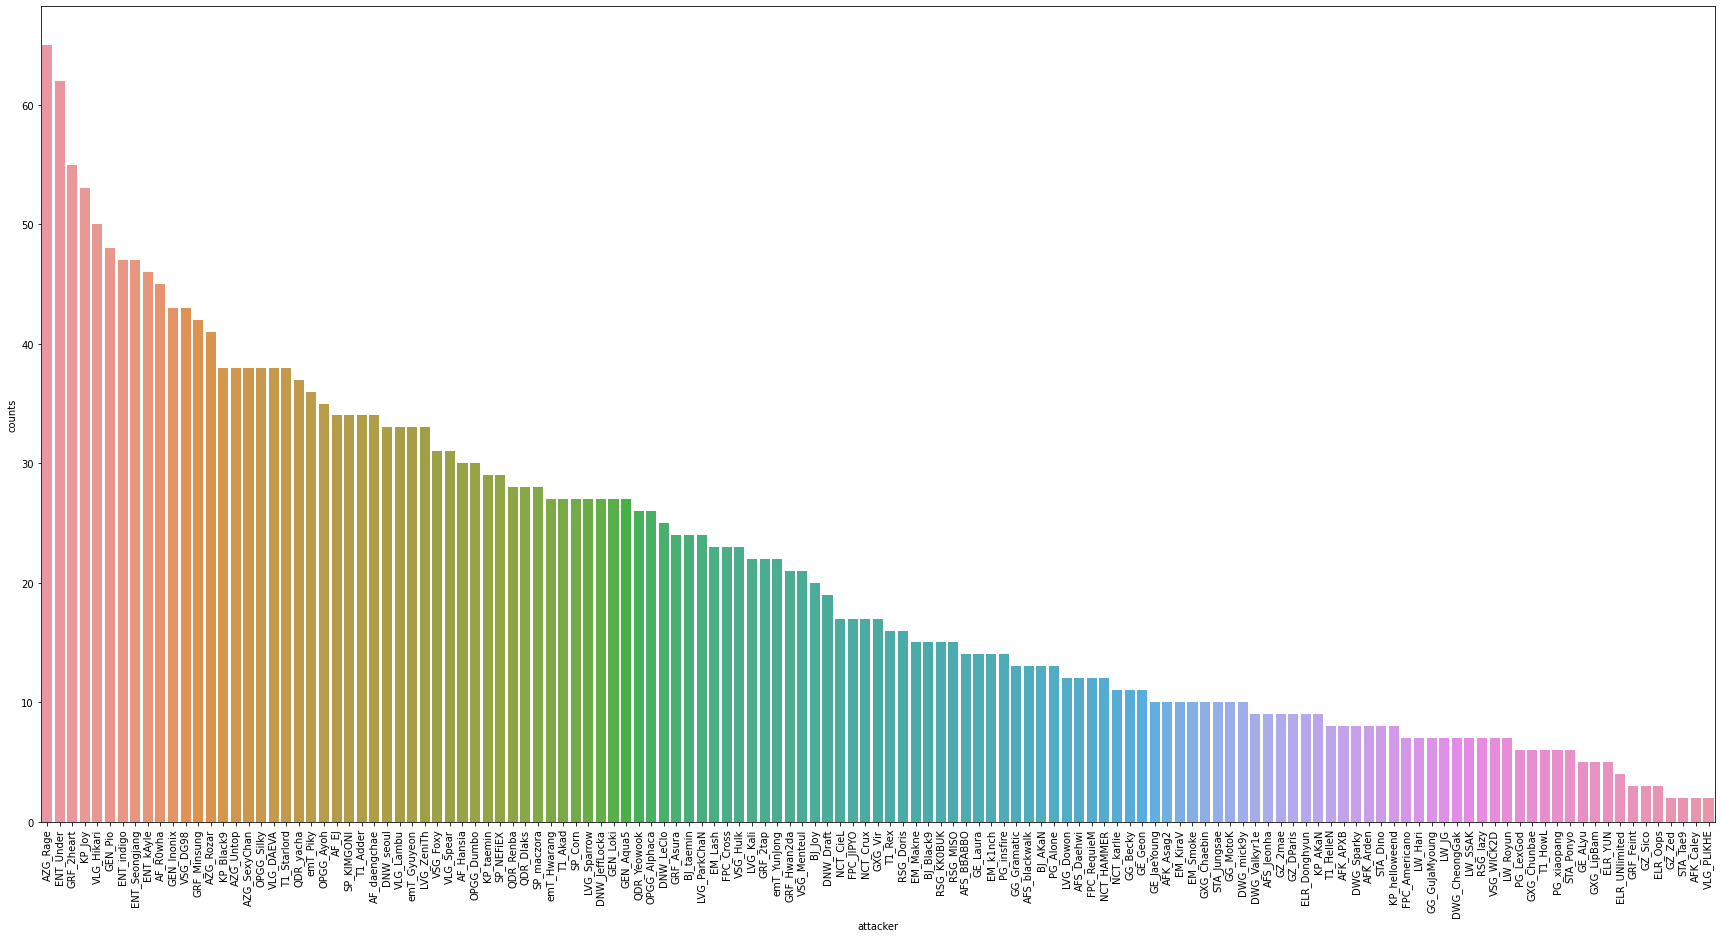

In [ ]:
#헤드샷 attack
plt.figure(figsize=(30,15))
bar_plot = sns.barplot(x = 'attacker', y = 'counts', data =df_a)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#헤드샷 kill
k= headshot_df['killer_name'].value_counts()
df_k = k.rename_axis('killer').reset_index(name = 'counts')
df_k

,killer,counts
0,GEN_Pio,12
1,AZG_Rage,11
2,GRF_2heart,10
3,GEN_Aqua5,9
4,ENT_Under,9
...,...,...
101,AFK_Arden,1
102,DWG_Valkyr1e,1
103,DWG_CheongGak,1
104,T1_Akad,1


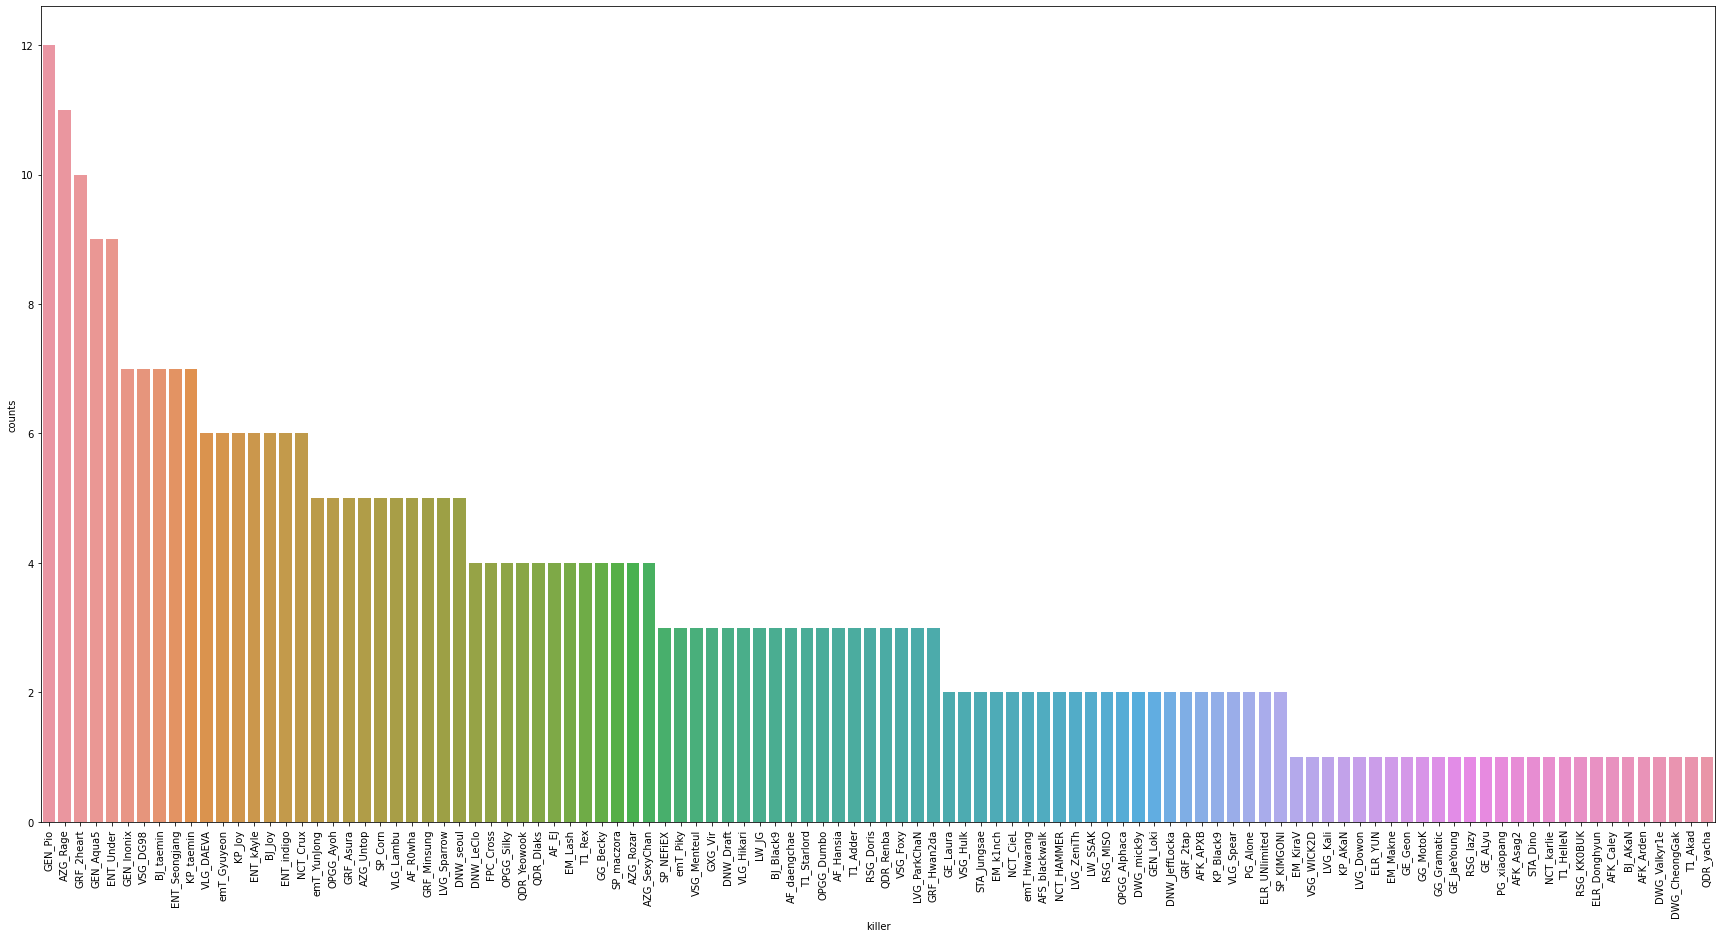

In [ ]:
#헤드샷 kill
plt.figure(figsize=(30,15))
bar_plot = sns.barplot(x = 'killer', y = 'counts', data =df_k)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# df_a + df+k 헤드샷 비율
headshot_count = pd.merge(df_a, df_k, how= 'left', left_on = 'attacker', right_on= 'killer')
headshot_count = headshot_count.fillna(0)
headshot_count['headshot_count']= headshot_count['counts_x'] + headshot_count['counts_y']
headshot_count = headshot_count.astype({'headshot_count': 'int'})
headshot_count

,attacker,counts_x,killer,counts_y,headshot_count
0,AZG_Rage,65,AZG_Rage,11.0,76
1,ENT_Under,62,ENT_Under,9.0,71
2,GRF_2heart,55,GRF_2heart,10.0,65
3,KP_Joy,53,KP_Joy,6.0,59
4,VLG_Hikari,50,VLG_Hikari,3.0,53
...,...,...,...,...,...
128,ELR_Oops,3,0,0.0,3
129,GZ_Zed,2,0,0.0,2
130,STA_Tae9,2,0,0.0,2
131,AFK_Caley,2,AFK_Caley,1.0,3


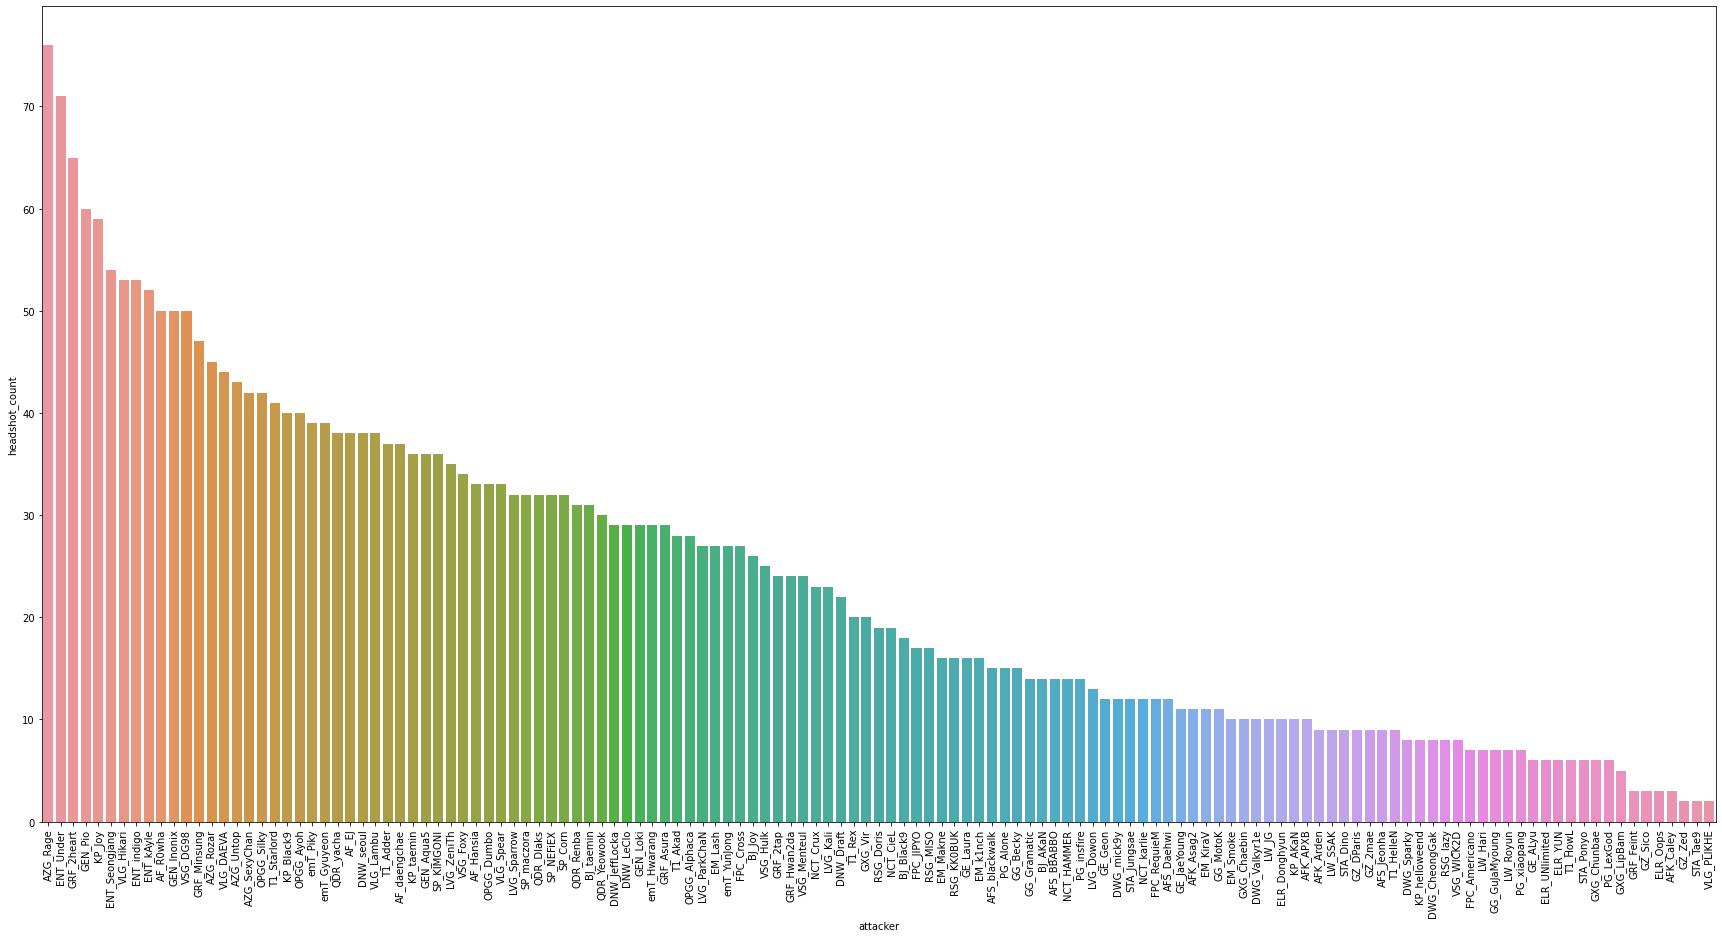

In [ ]:
#헤드샷 attack, kill
plt.figure(figsize=(30,15))
bar_plot = sns.barplot(x = 'attacker', y = 'headshot_count', data =headshot_count.sort_values(by = 'headshot_count', ascending = False))
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 헤드샷 비율
players_shot = shotacc_df[['name' ,'count_sum']]
head= headshot_count[['attacker','headshot_count']]

for_head = pd.merge(players_shot, head, how= 'left', left_on = 'name', right_on= 'attacker')
for_head.drop('attacker', axis=1, inplace=True)
for_head['headshot_ratio']= for_head['headshot_count'] / for_head['count_sum']
for_head

,name,count_sum,headshot_count,headshot_ratio
0,STA_Jungsae,986,12,0.012170
1,VSG_WICK2D,713,8,0.011220
2,LW_SSAK,863,9,0.010429
3,GZ_DParis,857,9,0.010502
4,GEN_Aqua5,3131,36,0.011498
...,...,...,...,...
128,STA_Ponyo,693,6,0.008658
129,ENT_indigo,3800,53,0.013947
130,GXG_Chaebin,801,10,0.012484
131,KP_Joy,3219,59,0.018329


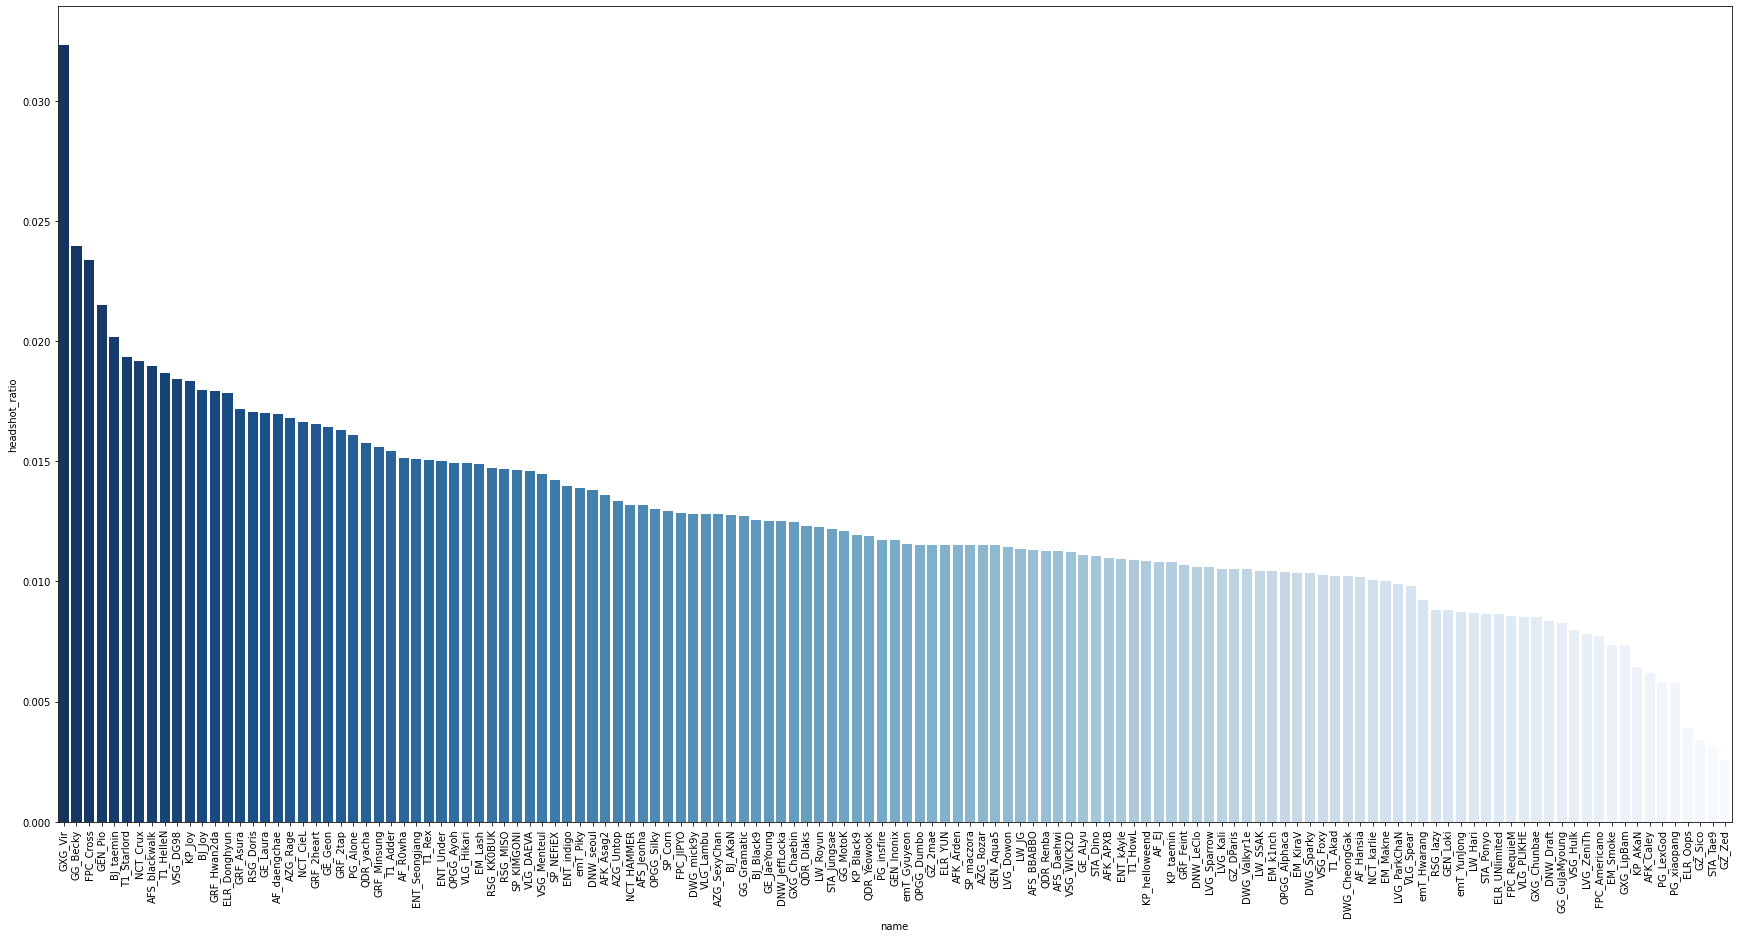

In [ ]:
#헤드샷 ratio, 평가기준 포함
plt.figure(figsize=(30,15))
bar_plot = sns.barplot(x = 'name', y = 'headshot_ratio', data =for_head.sort_values(by = 'headshot_ratio', ascending = False), palette='Blues_r')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# attacker, defender 명중률
ad_li = [] #atacker,defendr li

for i in range(len(merge_data)):
  ad_li.append(merge_data['_T'][i])
  ad_li.append(merge_data['damage'][i])
  ad_li.append(merge_data['damage_reason'][i])
  ad_li.append(merge_data['damage_type_category'][i])
  ad_li.append(merge_data['distance'][i])
  ad_li.append(merge_data['battle_type'][i])
  ad_li.append(merge_data['attacker_name'][i])
  ad_li.append(merge_data['victim_name'][i])
  ad_li.append(merge_data['killer_name'][i])

n= 9
result = [ad_li[i * n:(i + 1) * n] for i in range((len(ad_li) + n - 1) // n )] 
ad_df= pd.DataFrame(result, columns = ['_T','damage','damage_reason', 'damage_type_category', 'distance', 'battle_type', 'attacker_name', 'victim_name', 'killer_name'])

In [ ]:
attacker_df = ad_df[(ad_df.battle_type == 'Attacker')]
defender_df = ad_df[(ad_df.battle_type == 'Defender')]
notbattle_df = ad_df[(ad_df.battle_type == 'NotBattle')]

In [ ]:
attacker_df

,_T,damage,damage_reason,damage_type_category,distance,battle_type,attacker_name,victim_name,killer_name
0,LogPlayerTakeDamage,64.357788,HeadShot,Damage_Gun,NaN,Attacker,AZG_Untop,PG_LexGod,NaN
2,LogPlayerTakeDamage,0.000000,LegShot,Damage_Gun,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
3,LogPlayerTakeDamage,0.000000,TorsoShot,Damage_Gun,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
4,LogPlayerTakeDamage,0.000000,TorsoShot,Damage_Gun,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
5,LogPlayerTakeDamage,0.000000,TorsoShot,Damage_Gun,NaN,Attacker,PG_LexGod,AZG_Untop,NaN
...,...,...,...,...,...,...,...,...,...
246551,LogPlayerKill,NaN,TorsoShot,Damage_Gun,1458.110229,Attacker,NaN,SP_maczora,OPGG_Silky
246555,LogPlayerKill,NaN,PelvisShot,Damage_Gun,12269.474609,Attacker,NaN,GRF_Hwan2da,DNW_JeffLocka
246556,LogPlayerKill,NaN,None,Damage_Groggy,1649.201782,Attacker,NaN,AZG_Rozar,AF_daengchae
246562,LogPlayerKill,NaN,TorsoShot,Damage_Gun,2341.621582,Attacker,NaN,OPGG_Silky,SP_NEFiEX


In [ ]:
defender_df

,_T,damage,damage_reason,damage_type_category,distance,battle_type,attacker_name,victim_name,killer_name
1,LogPlayerTakeDamage,94.000000,HeadShot,Damage_Gun,NaN,Defender,PG_LexGod,AZG_Untop,NaN
8,LogPlayerTakeDamage,36.138000,TorsoShot,Damage_Gun,NaN,Defender,BJ_Joy,GZ_2mae,NaN
52,LogPlayerTakeDamage,30.360001,TorsoShot,Damage_Gun,NaN,Defender,GZ_Sico,STA_Jungsae,NaN
64,LogPlayerTakeDamage,23.243206,TorsoShot,Damage_Gun,NaN,Defender,PG_Alone,AZG_SexyChan,NaN
166,LogPlayerTakeDamage,25.810843,TorsoShot,Damage_Gun,NaN,Defender,FPC_Americano,GG_Becky,NaN
...,...,...,...,...,...,...,...,...,...
243985,LogPlayerAttack,NaN,NaN,NaN,NaN,Defender,VSG_DG98,NaN,NaN
243997,LogPlayerAttack,NaN,NaN,NaN,NaN,Defender,VSG_DG98,NaN,NaN
243998,LogPlayerAttack,NaN,NaN,NaN,NaN,Defender,VSG_DG98,NaN,NaN
243999,LogPlayerAttack,NaN,NaN,NaN,NaN,Defender,VSG_DG98,NaN,NaN


In [ ]:
notbattle_df #notbattle

,_T,damage,damage_reason,damage_type_category,distance,battle_type,attacker_name,victim_name,killer_name
530,LogPlayerAttack,NaN,NaN,NaN,NaN,NotBattle,AFK_APXB,NaN,NaN
539,LogPlayerAttack,NaN,NaN,NaN,NaN,NotBattle,AFK_APXB,NaN,NaN
578,LogPlayerAttack,NaN,NaN,NaN,NaN,NotBattle,FPC_Cross,NaN,NaN
579,LogPlayerAttack,NaN,NaN,NaN,NaN,NotBattle,FPC_Cross,NaN,NaN
580,LogPlayerAttack,NaN,NaN,NaN,NaN,NotBattle,FPC_Cross,NaN,NaN
...,...,...,...,...,...,...,...,...,...
246566,LogPlayerKill,NaN,PelvisShot,Damage_Gun,772.480408,NotBattle,NaN,DNW_JeffLocka,AF_daengchae
246567,LogPlayerKill,NaN,None,Damage_Groggy,7320.010254,NotBattle,NaN,DNW_seoul,AF_daengchae
246568,LogPlayerKill,NaN,None,Damage_Groggy,2129.467529,NotBattle,NaN,DNW_LeClo,AF_Hansia
246569,LogPlayerKill,NaN,TorsoShot,Damage_Gun,879.941956,NotBattle,NaN,DNW_Draft,AF_Hansia


In [ ]:
s = merge_data[ (merge_data['_T'] == 'LogPlayerAttack')].weapon[13781]

In [ ]:
import re
re.findall('\d+x', s)

['3x']

In [ ]:
scope_df.loc[13781].scope

In [ ]:
str(re.findall('\d+x', s))

"['3x']"

In [ ]:
import re
scope_df = merge_data.copy()
scope_df['scope'] = None

for i in range(len(merge_data)):
  if i % 1000 == 0:
    print(i)

  if scope_df.loc[i]['_T'] == 'LogPlayerAttack':
  
    s = scope_df.loc[i].weapon
    scope = str(re.findall('\d+x', s))
    scope_df.loc[i, 'scope'] = scope

  elif scope_df.loc[i]['_T'] == 'LogPlayerKill':
    s = scope_df.loc[i].damage_causer_additional_info
    scope = str(re.findall('\d+x', s))
    scope_df.loc[i, 'scope'] = scope

scope_df

In [ ]:
scope_df['scope'].unique()
scope_df['scope'].value_counts()

[]        172997
['6x']     39771
['3x']     12524
Name: scope, dtype: int64

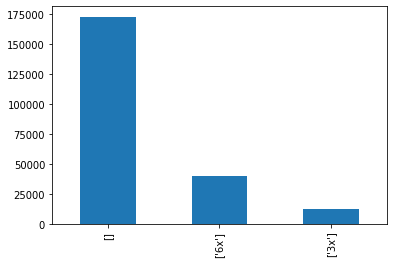

In [ ]:
scope_df['scope'].value_counts().plot(kind = 'bar');

In [ ]:
shotacc_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy
0,STA_Jungsae,884,91,11,986,0.103448
1,VSG_WICK2D,622,84,7,713,0.127630
2,LW_SSAK,800,59,4,863,0.073001
3,GZ_DParis,778,74,5,857,0.092182
4,GEN_Aqua5,2889,219,23,3131,0.077292
...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593
129,ENT_indigo,3416,341,43,3800,0.101053
130,GXG_Chaebin,672,119,10,801,0.161049
131,KP_Joy,2846,344,29,3219,0.115874


In [ ]:
for_head

,name,count_sum,headshot_count,headshot_ratio
0,STA_Jungsae,986,12,0.012170
1,VSG_WICK2D,713,8,0.011220
2,LW_SSAK,863,9,0.010429
3,GZ_DParis,857,9,0.010502
4,GEN_Aqua5,3131,36,0.011498
...,...,...,...,...
128,STA_Ponyo,693,6,0.008658
129,ENT_indigo,3800,53,0.013947
130,GXG_Chaebin,801,10,0.012484
131,KP_Joy,3219,59,0.018329


In [ ]:
final_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio
0,STA_Jungsae,884,91,11,986,0.103448,0.012170
1,VSG_WICK2D,622,84,7,713,0.127630,0.011220
2,LW_SSAK,800,59,4,863,0.073001,0.010429
3,GZ_DParis,778,74,5,857,0.092182,0.010502
4,GEN_Aqua5,2889,219,23,3131,0.077292,0.011498
...,...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593,0.008658
129,ENT_indigo,3416,341,43,3800,0.101053,0.013947
130,GXG_Chaebin,672,119,10,801,0.161049,0.012484
131,KP_Joy,2846,344,29,3219,0.115874,0.018329


In [ ]:
final_df = pd.concat([shotacc_df, for_head['headshot_ratio']], axis=1)
final_df.describe()

,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,1677.631579,160.000000,16.293233,1853.924812,0.094676,0.012479
std,1048.266184,106.411295,11.679937,1158.488472,0.024263,0.004202
min,213.000000,11.000000,1.000000,235.000000,0.039693,0.002561
25%,800.000000,74.000000,7.000000,863.000000,0.081180,0.010336
50%,1238.000000,120.000000,12.000000,1360.000000,0.093617,0.011718
75%,2555.000000,231.000000,25.000000,2793.000000,0.110132,0.014876
max,4342.000000,501.000000,52.000000,4756.000000,0.175719,0.032310


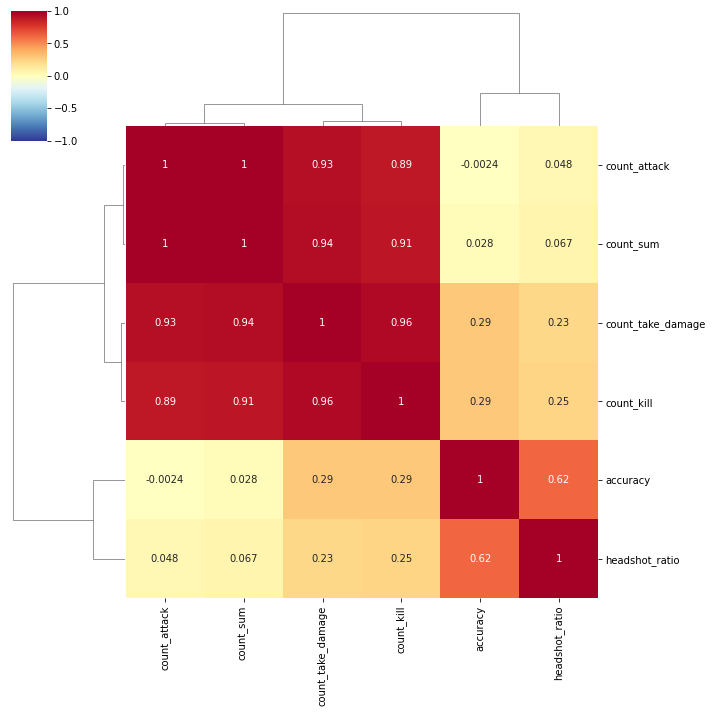

In [ ]:
df_cor = final_df.corr()

sns.clustermap(df_cor, 
               annot = True,      
               cmap = 'RdYlBu_r',  
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
final_df['accuracy'].quantile(0.1)

0.06549870451729188

In [ ]:
acc_quantile = []
head_quantile = []
for i in range(0, 9):
  acc_quantile.append(final_df['accuracy'].quantile(0.1 + i/10))
  head_quantile.append(final_df['headshot_ratio'].quantile(0.1 + i/10))

In [ ]:
acc_quantile # shot 10분위값

[0.06549870451729188,
 0.07728798783621027,
 0.08352684330653964,
 0.08777427910197048,
 0.09361702127659574,
 0.09736282525593017,
 0.10688609773116814,
 0.1129487097234841,
 0.12203744885586923]

In [ ]:
head_quantile #head 10분위 값

[0.008270440251572328,
 0.009934065934065935,
 0.01051071383410724,
 0.011241227649318914,
 0.011717834544176237,
 0.012751277865028722,
 0.014057309941520466,
 0.015299804987265455,
 0.017692202217089094]

In [ ]:
final_df.loc[:, 'acc_rating'] = [0] *133

In [ ]:
final_df.loc[:, 'head_rating'] = [0] *133

In [ ]:
final_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio,acc_rating,head_rating
0,STA_Jungsae,884,91,11,986,0.103448,0.012170,0,0
1,VSG_WICK2D,622,84,7,713,0.127630,0.011220,0,0
2,LW_SSAK,800,59,4,863,0.073001,0.010429,0,0
3,GZ_DParis,778,74,5,857,0.092182,0.010502,0,0
4,GEN_Aqua5,2889,219,23,3131,0.077292,0.011498,0,0
...,...,...,...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593,0.008658,0,0
129,ENT_indigo,3416,341,43,3800,0.101053,0.013947,0,0
130,GXG_Chaebin,672,119,10,801,0.161049,0.012484,0,0
131,KP_Joy,2846,344,29,3219,0.115874,0.018329,0,0


In [ ]:
# 사격정확도, 헤드샷 10분위

for i in range(len(final_df)):
  for j in range(len(acc_quantile)):
    if acc_quantile[j] > final_df.loc[i].accuracy:
      break
    if j == 8: 
      j += 1
  
  final_df.loc[i, 'acc_rating'] = j + 1

  for j in range(len(head_quantile)):
    if head_quantile[j] > final_df.loc[i].headshot_ratio:
      break
    if j == 8: 
      j += 1
  
  final_df.loc[i, 'head_rating'] = j + 1

In [ ]:
final_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio,acc_rating,head_rating
0,STA_Jungsae,884,91,11,986,0.103448,0.012170,7,6
1,VSG_WICK2D,622,84,7,713,0.127630,0.011220,9,4
2,LW_SSAK,800,59,4,863,0.073001,0.010429,2,3
3,GZ_DParis,778,74,5,857,0.092182,0.010502,5,3
4,GEN_Aqua5,2889,219,23,3131,0.077292,0.011498,3,5
...,...,...,...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593,0.008658,2,2
129,ENT_indigo,3416,341,43,3800,0.101053,0.013947,7,7
130,GXG_Chaebin,672,119,10,801,0.161049,0.012484,9,6
131,KP_Joy,2846,344,29,3219,0.115874,0.018329,9,9


In [ ]:
# 마지막 계산
for i in range(133):
  final_df.loc[i, 'total_rating'] = (final_df.loc[i, 'acc_rating'] + final_df.loc[i, 'head_rating']) / 2

final_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio,acc_rating,head_rating,total_rating
0,STA_Jungsae,884,91,11,986,0.103448,0.012170,7,6,6.5
1,VSG_WICK2D,622,84,7,713,0.127630,0.011220,9,4,6.5
2,LW_SSAK,800,59,4,863,0.073001,0.010429,2,3,2.5
3,GZ_DParis,778,74,5,857,0.092182,0.010502,5,3,4.0
4,GEN_Aqua5,2889,219,23,3131,0.077292,0.011498,3,5,4.0
...,...,...,...,...,...,...,...,...,...,...
128,STA_Ponyo,642,47,4,693,0.073593,0.008658,2,2,2.0
129,ENT_indigo,3416,341,43,3800,0.101053,0.013947,7,7,7.0
130,GXG_Chaebin,672,119,10,801,0.161049,0.012484,9,6,7.5
131,KP_Joy,2846,344,29,3219,0.115874,0.018329,9,9,9.0


In [ ]:
final_df.sort_values('total_rating', ascending = False)

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio,acc_rating,head_rating,total_rating
68,AZG_Rage,3974,501,52,4527,0.122156,0.016788,9,9,9.0
10,GE_Laura,828,101,12,941,0.120085,0.017003,9,9,9.0
58,GEN_Pio,2403,346,44,2793,0.139635,0.021482,9,9,9.0
40,VSG_DG98,2372,317,28,2717,0.126978,0.018403,9,9,9.0
62,T1_Starlord,1843,253,26,2122,0.131480,0.019321,9,9,9.0
...,...,...,...,...,...,...,...,...,...,...
52,PG_LexGod,968,62,5,1035,0.064734,0.005797,1,1,1.0
110,VSG_Hulk,2947,173,15,3135,0.059968,0.007974,1,1,1.0
57,GZ_Sico,830,49,5,884,0.061086,0.003394,1,1,1.0
91,STA_Tae9,610,27,3,640,0.046875,0.003125,1,1,1.0


In [ ]:
top16_df = final_df.sort_values('total_rating', ascending = False).head(16)
top16_df

,name,count_attack,count_take_damage,count_kill,count_sum,accuracy,headshot_ratio,acc_rating,head_rating,total_rating
68,AZG_Rage,3974,501,52,4527,0.122156,0.016788,9,9,9.0
10,GE_Laura,828,101,12,941,0.120085,0.017003,9,9,9.0
58,GEN_Pio,2403,346,44,2793,0.139635,0.021482,9,9,9.0
40,VSG_DG98,2372,317,28,2717,0.126978,0.018403,9,9,9.0
62,T1_Starlord,1843,253,26,2122,0.131480,0.019321,9,9,9.0
73,BJ_taemin,1362,153,23,1538,0.114434,0.020156,9,9,9.0
36,PG_Alone,819,104,10,933,0.122186,0.016077,9,9,9.0
61,GRF_2heart,3475,416,41,3932,0.116226,0.016531,9,9,9.0
102,GRF_Minsung,2652,330,37,3019,0.121563,0.015568,9,9,9.0
82,AFS_blackwalk,699,83,10,792,0.117424,0.018939,9,9,9.0


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_

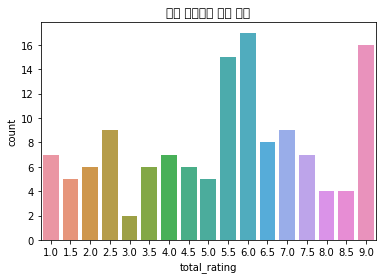

In [ ]:
sns.countplot(x="total_rating", data=final_df)
plt.title("사격 점수대별 선수 분포")
plt.show()